# **Imports and Constants**

In [1]:
#find spark
import findspark
findspark.init()

In [2]:
#imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier,MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, isnan, array_contains, when, count, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd 
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics
import pathlib
import platform

#env variables 
if platform.system()=='Windows':
    %env PYSPARK_DRIVER_PYTHON=python
    %env PYSPARK_PYTHON=python
elif platform.system()=='Linux':
    %env PYSPARK_DRIVER_PYTHON=python
    %env PYSPARK_PYTHON=python3
else:
    %env PYSPARK_DRIVER_PYTHON=python3.6 
    %env PYSPARK_PYTHON=python3.6 

#incompatibility with Pyarrow
#need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
%env ARROW_PRE_0_15_IPC_FORMAT=1 

#used versions: 
#spark='2.4.3' python='3.6' pyarrow='0.14.1' 

#for new system:
#import findspark
#findspark.init()
#%pip install numpy
#%pip install -U matplotlib
#%pip install pandas
#%pip install Pyarrow==0.14.0
#%env PYSPARK_DRIVER_PYTHON=python
#%env PYSPARK_PYTHON=python

env: PYSPARK_DRIVER_PYTHON=python3.6
env: PYSPARK_PYTHON=python3.6
env: ARROW_PRE_0_15_IPC_FORMAT=1


In [3]:
#paths

BASE_PATH=pathlib.Path().absolute()

KMEANS_REL_PATH="kmeans models"
DATASET_REL_PATH="dataset"


DATASET_PATH=os.path.join(BASE_PATH,DATASET_REL_PATH)
KMEANS_PATH=os.path.join(BASE_PATH,KMEANS_REL_PATH)

#print(DATASET_PATH)
#print(KMEANS_PATH)

#from google.colab import drive
#drive.mount('/gdrive')

# **Load/Save Dataset**

In [4]:
#load and save .read_pickle() and .to_pickle() 

#save
#dataset.to_pickle(DATASET_PATH+"dataset.pkl")
#aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
#dataset.to_csv(DATASET_PATH+"dataset.csv")
#aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
#json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
#aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")

#load
dataset=pd.read_pickle(os.path.join(DATASET_PATH, 'dataset.pkl'))
aggregated_dataset=pd.read_pickle(os.path.join(DATASET_PATH, 'aggregated_dataset.pkl'))


# **Malicious Samples**

In [5]:
# Generate malicious samples
def h1(x):
    MAX=0.8
    MIN=0.1
    alpha=random.uniform(MIN,MAX)
    temp=np.array(x)
    return (temp*alpha).tolist()

def h2(x):
    MIN_OFF=4 # hour
    DURATION=random.randint(MIN_OFF,23)
    START=random.randint(0,23-DURATION) if DURATION!=23 else 0
    END=START+DURATION
    temp=[]
    for i in range(len(x)):
        if i<START or i>=END:
            temp.append(x[i])
        else:
            temp.append(0.0)
    return temp
    
def h3(x):
    MAX=0.8
    MIN=0.1
    temp=[]
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN,MAX))
    return temp

def h4(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN,MAX))
    return temp

def h5(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean)
    return temp

def h6(x):
    temp=np.array(x)
    #temp=temp[::-1] 
    temp=np.flipud(temp) 
    return temp.tolist()


#add malicious samples
def create_malicious_df(sdf):
    def random_attack_assigner(x):
        NUMBER_OF_MALICIOUS_GENERATOR=6
        res=[]
        for row in x:
            rand = random.randint(1,NUMBER_OF_MALICIOUS_GENERATOR)
            if rand==1:
                temp=(h1(row))
            elif rand==2:
                temp=(h2(row))
            elif rand==3:
                temp=(h3(row))
            elif rand==4:
                temp=(h4(row))
            elif rand==5:
                temp=(h5(row))
            elif rand==6:
                temp=(h6(row))
            res.append(temp)
        return pd.Series(res)
    random_attack_assigner_UDF = pandas_udf(random_attack_assigner, returnType=ArrayType(FloatType()))
    #sdf_malicious=sdf
    N=False
    sdf=sdf.withColumn("N", f.lit(N)) #malicious sample
    sdf=sdf.withColumn("#", col("#")*-1) # change '#' column number to negative
    sdf=sdf.withColumn("power",random_attack_assigner_UDF(col("power")))
    #sdf=sdf.drop('statistics') 
    sdf=sdf.withColumn("statistics",generate_feature_UDF(col("power")))
    sdf=add_statistics_column(sdf) #for update statistics
    return sdf.select(sdf.columns) #to reorder columns


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


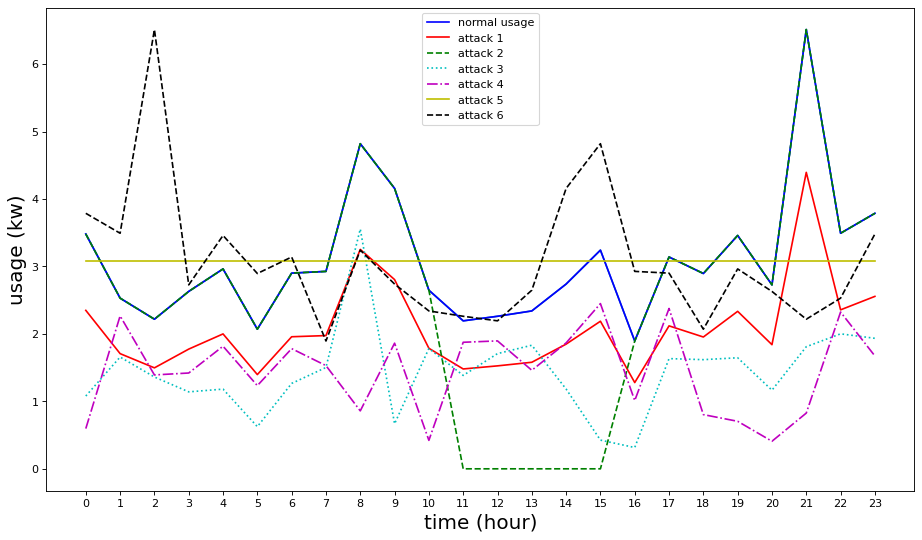

In [24]:
#plot
def plot_malicious_samples():
    #read_value=[96.00396728515625, 68.20671844482422, 96.05184936523438, 81.24053192138672, 107.14600372314453, 85.7899169921875, 100.9619140625, 181.16192626953125, 122.7833023071289, 119.53163146972656, 107.34815216064453, 108.99268341064453, 139.76922607421875, 97.21031951904297, 118.4515151977539, 99.15070343017578, 85.47505187988281, 81.51718139648438, 232.91493225097656, 82.83419799804688, 108.6827163696289, 95.99102020263672, 90.59868621826172, 85.60449981689453]
    read_value=[3.4803431034088135,
 2.529871702194214,
 2.2175486087799072,
 2.629481077194214,
 2.9629790782928467,
 2.0697860717773438,
 2.900712251663208,
 2.926414966583252,
 4.8191237449646,
 4.156486988067627,
 2.6474769115448,
 2.1933677196502686,
 2.261159658432007,
 2.340345621109009,
 2.7386586666107178,
 3.2414891719818115,
 1.8946533203125,
 3.1397650241851807,
 2.8951449394226074,
 3.4589333534240723,
 2.726524829864502,
 6.511429309844971,
 3.4918391704559326,
 3.787257432937622]
    lists=[]
    colors=['b','r-','g--','c:','m-.','y-','k--']
    lists.append(read_value)
    lists.append(h1(read_value))
    lists.append(h2(read_value))
    lists.append(h3(read_value))
    lists.append(h4(read_value))
    lists.append(h5(read_value))
    lists.append(h6(read_value))
    #font = {'size': 12}
    #plt.rc('font', **font)
    plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("time (hour)",fontsize=18)
    plt.ylabel("usage (kw)",fontsize=18)
    #plt.title("malicious samples")
    plt.xticks(np.arange(0, 24, step=1))
    plt.plot(read_value)
    for i in range(len(lists)):
        if i == 0:
            plt.plot(lists[i],colors[i],label = 'normal usage')
        else:
            plt.plot(lists[i],colors[i],label = 'attack %s'%i)
    plt.legend()
    plt.savefig('attack.pdf',bbox_inches='tight')  
    plt.savefig('attack.eps', format='eps')
    plt.show()
    return None

plot_malicious_samples()


# **Prepare Spark Dataset**

In [7]:
#rename columns
def rename_dataframe(sdf):
    names = ['#','date','id','power']
    for c,n in zip(sdf.columns,names):
        sdf=sdf.withColumnRenamed(c,n)
    return sdf
    
#sdf=rename_dataframe(sdf)
#sdf.show()
    
#convert power to array
def string_power_to_array(sdf):
    temp=sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""),"\\]","")
                        .alias("power"))
    temp=temp.withColumn("power",split(col("power"), ",\s*")
                        .cast(ArrayType(FloatType())).alias("power"))
    return temp

#sdf=string_power_to_array(sdf)
#sdf.show()

def add_validation_column(sdf):
    def validation(x):
        res=[]
        for row in x:
            v=True
            if (len(row)!= 24 or # unusual size
                (row>=0).sum()!=24 or #number of valid elements = 24
                #sum(n >= 0 for n in row) != 24 or 
                np.count_nonzero(row == 0)>=3 or #equal or more than 3 zero elements
                sum(n < 0 for n in row) > 0): #not have negative element
                    v=False
            res.append(v)
        return pd.Series(res)
    validation_UDF = pandas_udf(validation, returnType=BooleanType())
    temp=sdf.withColumn("V",validation_UDF(col("power")))
    return temp

#sdf=add_validation_column(sdf)
#sdf.show()


#add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N=True
    temp=sdf.withColumn("N", f.lit(N))
    return temp

#sdf=add_Normal_column(sdf)
#sdf.show()

#filter data
def filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="*",V="*"):
    temp=sdf
    if (from_date!="BEGIN"):
        temp=temp.filter(sdf.date > from_date) #filter date (from X)
    if (to_date!="END"):
        temp=temp.filter(sdf.date < to_date) #filter date (to Y)
    if (ID!="*"):
        temp=temp.filter(sdf.id == ID) #filter IDs
    if (V!="*"):
        temp=temp.filter(sdf.V == V) #filter validation    
    return temp

#sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="Apt36",V="True")
#sdf.show()

def split_power(sdf):
    temp=sdf.select("#","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
    return temp
    
#split_sdf=split_power(sdf)
#sdf.show()

#make id list
def get_ids(sdf):
    IDs=np.array(sdf.select("id").distinct().collect())
    IDs=IDs.reshape(1,len(IDs))
    return IDs


#generate uniqe id
def generate_uniqe_id(sdf):
    temp=sdf
    temp=temp.withColumn("uid",f.concat(col("id"),f.lit("-"),col("#")).alias("uid"))
    return temp

#sdf=generate_uniqe_id(sdf)


#generate feature
def generate_feature(x):
        res=[]
        for row in x:
            row=np.array(row) # to numpy
            statistics=[]
            min_val=np.nanmin(row)
            max_val=np.nanmax(row)
            mean_val=np.nanmean(row)
            std_val=np.nanstd(row)
            statistics.append(mean_val)
            statistics.append(std_val)
            statistics.append(min_val)
            statistics.append(max_val)
            res.append(statistics)
        return pd.Series(res)

generate_feature_UDF = pandas_udf(generate_feature, returnType=ArrayType(FloatType()))
    
def add_statistics_column(sdf):
    temp=sdf.withColumn("statistics",generate_feature_UDF(col("power")))
    return temp

#sdf=add_statistics_column(sdf)
#sdf.show()


#sdf.show()
#print("number of rows: " + str(sdf.count()))
#sdf.collect()
#sdf.printSchema()
#split_sdf=add_validation_column(split_sdf)

# **K-Means**

In [8]:
def prepare_for_kmeans(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"),
           sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"),sdf.statistics[3].alias("S3"))
        return temp
    
    #call the split_power function
    temp=split(temp)
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23','S0','S1','S2','S3']
    
    #call the generate_uniqe_id function
    temp=generate_uniqe_id(temp)
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_kmeans = vecAssembler.transform(temp).select(col("uid"), col("features"))
    return df_kmeans


In [9]:
#run k-means

def kmeans(sdf_kmeans):
    #find best k
    MAX_k=5
    costs = np.zeros(MAX_k)
    silhouettes = np.zeros(MAX_k)
    silhouettes[1]=0 #set value for k=1
    for k in range(2,MAX_k):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(sdf_kmeans)
        costs[k] = model.computeCost(sdf_kmeans) # requires Spark 2.0 or later
        predictions = model.transform(sdf_kmeans)
        evaluator = ClusteringEvaluator()
        silhouettes[k] = evaluator.evaluate(predictions)

#     #show silhouette
#     fig, ax = plt.subplots(1,1, figsize =(8,6))
#     ax.plot(range(2,MAX_k),silhouettes[2:MAX_k])
#     ax.set_xlabel('k')
#     ax.set_ylabel('silhouette')

#     #show cost
#     fig, ax = plt.subplots(1,1, figsize =(8,6))
#     ax.plot(range(2,MAX_k),costs[2:MAX_k])
#     ax.set_xlabel('k')
#     ax.set_ylabel('cost')

    # find best k
    best_k = np.argmax(silhouettes)
    print("maximum value of silhouette is: " + str(silhouettes[best_k]) + " in index: " + str(best_k) )

    # Trains a k-means model.
    kmeans = KMeans().setK(best_k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)

    # Make predictions
    predictions = model.transform(sdf_kmeans)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
#    print("Silhouette with squared euclidean distance = " + str(silhouette))

#     # Shows the result.
#     centers = model.clusterCenters()
#     print("Cluster Centers: ")
#     for center in centers:
#         print(center)

#     transformed = model.transform(sdf_kmeans).select('id', 'prediction')
#     transformed.show()
#     transformed.groupby('prediction').count().show()
#     rows = transformed.collect() 
#     prediction = spark.createDataFrame(rows)
#     prediction.show()
    return model,best_k,silhouette


# **Decision Tree Methods**

In [10]:
def prepare_for_decision_tree_methods(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"),
           sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"),sdf.statistics[3].alias("S3"))
        return temp
    
    #call the split_power function
    temp=split(temp)
    
    #boolean to string (for "N" column)
    temp=temp.withColumn("N",f.col("N").cast('string'))
    #temp.printSchema()
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23','S0','S1','S2','S3']
    
    #call the generate_uniqe_id function
    #temp=generate_uniqe_id(temp)
    
    #make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    
    #make label ready
    indexer = StringIndexer(inputCol="N", outputCol="NIndex")
    output_fixed = indexer.fit(output).transform(output)
    
    final_data = output_fixed.select("features",'NIndex')
    return final_data


In [11]:
#run decision tree methods
def decision_tree(train_data,test_data):
    dtc = DecisionTreeClassifier(labelCol='NIndex',featuresCol='features')
    rfc = RandomForestClassifier(labelCol='NIndex',featuresCol='features') #,numTrees=100
    gbt = GBTClassifier(labelCol='NIndex',featuresCol='features')

    dtc_model = dtc.fit(train_data)
    rfc_model = rfc.fit(train_data)
    gbt_model = gbt.fit(train_data)

    dtc_predictions = dtc_model.transform(test_data)
    rfc_predictions = rfc_model.transform(test_data)
    gbt_predictions = gbt_model.transform(test_data)
    
    #evaluation
    # Select (prediction, true label) and compute test error
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="NIndex", predictionCol="prediction", metricName="accuracy")

    dtc_acc = acc_evaluator.evaluate(dtc_predictions)
    rfc_acc = acc_evaluator.evaluate(rfc_predictions)
    gbt_acc = acc_evaluator.evaluate(gbt_predictions)

    #print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
    #print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
    #print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
    
    return dtc_acc,rfc_acc,gbt_acc


# **PCA**

In [12]:
def prepare_for_pca(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']

    #call the generate_uniqe_id function
    temp=generate_uniqe_id(temp)
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_pca = vecAssembler.transform(temp).select("#", "V", "N", "date", "id", "uid", col("features"))
    return df_pca


def pca_for_tree(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select("NIndex",col("pcaFeatures").alias("features"))
    return result


def pca_for_kmeans(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select("uid",col("pcaFeatures").alias("features"))
    return result


#sdf_pca=pca(sdf)
#sdf_pca.show() #truncate=False

# **MLP**

In [13]:
def prepare_for_mlp(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"),
           sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"),sdf.statistics[3].alias("S3"))
        return temp
    
    #call the split_power function
    temp=split(temp)
    
    #boolean to string (for "N" column)
    temp=temp.withColumn("N",f.col("N").cast('string'))
    #temp.printSchema()
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23','S0','S1','S2','S3']
    
    #call the generate_uniqe_id function
    #temp=generate_uniqe_id(temp)
    
    #make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    
    #make label ready
    indexer = StringIndexer(inputCol="N", outputCol="label")
    output_fixed = indexer.fit(output).transform(output)
    
    final_data = output_fixed.select("features",'label')
    return final_data


In [14]:
#run mlp method
def mlp(train_data,test_data,layers = [28, 50, 10, 2]):
    # specify layers for the neural network:
    # input layer of size 4 (features), two intermediate of size 5 and 4
    # and output of size 3 (classes)

    # create the trainer and set its parameters
    trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

    #train_data.show()
    # train the model
    model = trainer.fit(train_data)

    # compute accuracy on the test set
    result = model.transform(test_data)
    predictionAndLabels = result.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy") #BinaryClassificationEvaluator
    acc=evaluator.evaluate(predictionAndLabels)
    print("Test set accuracy = " + str(acc))
    return acc


# **Main**

In [15]:
#create SparkSession
spark = SparkSession.builder.appName("anomaly_detection").master("local[20]").getOrCreate()
#network problem? type it in commandline: sudo hostname -s 127.0.0.1

#define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
    StructField("power", StringType())])

#read data
sdf = spark.read.format('csv').options(header='true',inferSchema=True ,schema=schema).load(
    os.path.join(DATASET_PATH, 'aggregated_dataset_rowBased.csv'))


sdf=rename_dataframe(sdf)
sdf=string_power_to_array(sdf)
sdf=add_statistics_column(sdf)
sdf=add_validation_column(sdf)
sdf=add_Normal_column(sdf)
sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="*",V="True")
sdf=generate_uniqe_id(sdf)

#ids
id_list=get_ids(sdf)

# #dataset
# print("dataframe schema:")
# print("number of rows: " + str(sdf.count()))
# sdf.printSchema()
print("benign dataframe (sdf):")
sdf.show()

# #generate malicious data
sdf_malicious=create_malicious_df(sdf)
print("malicious dataframe (sdf_malicious):")
sdf_malicious.show()

sdf_mix= sdf.union(sdf_malicious)
print("final dataframe (sdf_mix):")
sdf_mix.show()


benign dataframe (sdf):
+-----+-------------------+------+--------------------+--------------------+----+----+------------+
|    #|               date|    id|               power|          statistics|   V|   N|         uid|
+-----+-------------------+------+--------------------+--------------------+----+----+------------+
|37325|2014-08-15 00:00:00|Apt102|[0.7486811, 0.350...|[0.8179619, 0.546...|true|true|Apt102-37325|
| 4341|2014-08-15 00:00:00|Apt105|[0.75559086, 0.37...|[0.6293783, 0.355...|true|true| Apt105-4341|
|68573|2014-08-15 00:00:00|Apt106|[5.0E-5, 5.0E-5, ...|[5.0E-5, 0.0, 5.0...|true|true|Apt106-68573|
|53817|2014-08-15 00:00:00|Apt111|[0.7907822, 0.604...|[0.56222486, 0.16...|true|true|Apt111-53817|
|21701|2014-08-15 00:00:00|Apt114|[0.053857777, 0.0...|[0.12976237, 0.16...|true|true|Apt114-21701|
|46873|2014-08-15 00:00:00|  Apt2|[0.08175, 0.34430...|[0.28781494, 0.35...|true|true|  Apt2-46873|
|20833|2014-08-15 00:00:00| Apt27|[0.0399825, 0.030...|[0.053037703, 0.0...|

In [23]:
sdf.collect()[8027][3]

[3.4803431034088135,
 2.529871702194214,
 2.2175486087799072,
 2.629481077194214,
 2.9629790782928467,
 2.0697860717773438,
 2.900712251663208,
 2.926414966583252,
 4.8191237449646,
 4.156486988067627,
 2.6474769115448,
 2.1933677196502686,
 2.261159658432007,
 2.340345621109009,
 2.7386586666107178,
 3.2414891719818115,
 1.8946533203125,
 3.1397650241851807,
 2.8951449394226074,
 3.4589333534240723,
 2.726524829864502,
 6.511429309844971,
 3.4918391704559326,
 3.787257432937622]

In [119]:
#kmeans separately

def call_kmeans(sdf):
    
    #create statistics dataframe
    kmeans_statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("k", IntegerType()),
    StructField("Silhouette", FloatType())])

    kmeans_statistics = spark.createDataFrame([], kmeans_statistics_schema)    
    
    id_list=get_ids(sdf)
    sdf_kmeans=prepare_for_kmeans(sdf) # replace sdf with final_sdf for clustring benign and malicious data
    #sdf_kmeans=pca_for_kmeans(sdf_kmeans) #0.8725788926917551 to 0.9101118371931005
    #sdf_kmeans.show()
    iteration=1
    for i in np.nditer(id_list):
        sdf_kmeans_by_id = sdf_kmeans.filter(sdf_kmeans.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        #sdf_kmeans_by_id.show()
        kmeans_model,best_k,silhouette=kmeans(sdf_kmeans_by_id)
        #kmeans_model.save(os.path.join(KMEANS_PATH,str(i)))
        
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette))])
        kmeans_statistics = kmeans_statistics.union(newRow_for_statistics)
        
        iteration+=1
        #model_name = KMeansModel.load(os.path.join(KMEANS_PATH,str(i)) #for load model
    return kmeans_statistics

print("-------------------- k-means started!")
kmeans_statistics=call_kmeans(sdf)
kmeans_statistics.show()
#save
# result_pdf = kmeans_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
#df.head()
#df.describe()

-------------------- k-means started!
customer 1: Apt10
maximum value of silhouette is: 0.8763767134387135 in index: 2
+-----+---+------------------+
|   id|  k|        Silhouette|
+-----+---+------------------+
|Apt10|  2|0.8763767134387135|
+-----+---+------------------+



In [65]:
#decision tree separately
def call_trees(sdf):
    
    #create statistics dataframe
    trees_statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("dtc", FloatType()),
    StructField("rfc", FloatType()),
    StructField("gbt", FloatType())])

    trees_statistics = spark.createDataFrame([], trees_statistics_schema)  
    
    id_list=get_ids(sdf)
    
    iteration=1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        
        sdf_trees=prepare_for_decision_tree_methods(sdf)
        train_data,test_data = sdf_trees.randomSplit([0.7,0.3])

        dtc_acc,rfc_acc,gbt_acc=decision_tree(train_data,test_data)
        print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
        print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
        print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
        
        newRow_for_statistics = spark.createDataFrame([(str(i), float(dtc_acc), float(rfc_acc), float(gbt_acc))])
        trees_statistics = trees_statistics.union(newRow_for_statistics)
        
        iteration+=1
    return trees_statistics
  
#print("-------------------- decision tree started!")
#trees_statistics=call_trees(sdf_mix)
#trees_statistics.show()
#save
# result_pdf = trees_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'trees_statistics.pkl'))
#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'trees_statistics.pkl'))
#df.head()

-------------------- decision tree started!
customer 1: Apt99
A single decision tree had an accuracy of: 64.50%
A random forest ensemble had an accuracy of: 69.70%
A ensemble using GBT had an accuracy of: 72.94%
+-----+-----------------+-----------------+------------------+
|   id|              dtc|              rfc|               gbt|
+-----+-----------------+-----------------+------------------+
|Apt99|0.645021645021645|0.696969696969697|0.7294372294372294|
+-----+-----------------+-----------------+------------------+



In [17]:
#mlp separetely
def call_mlp(sdf):
    
    #create statistics dataframe
    mlp_statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("mlp", FloatType())])

    mlp_statistics = spark.createDataFrame([], mlp_statistics_schema)  
    
    id_list=get_ids(sdf)
    
    iteration=1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        
        sdf_mlp=prepare_for_mlp(sdf)
        train_data,test_data = sdf_mlp.randomSplit([0.7,0.3])
        
        
        acc = mlp(train_data,test_data,[28,60,10,2])

        print('A MLP had an accuracy of: {0:2.2f}%'.format(acc*100))
        
        newRow_for_statistics = spark.createDataFrame([(str(i), float(acc))])
        mlp_statistics = mlp_statistics.union(newRow_for_statistics)
        
        iteration+=1
    return mlp_statistics

print("-------------------- mlp started!")
#run
mlp_statistics=call_mlp(sdf_mix)
mlp_statistics.show()

#save
#df = statistics.select("*").toPandas()
#df.to_pickle(os.path.join(BASE_PATH, 'mlp_statistics.pkl'))

#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'mlp_statistics.pkl'))
#df.head()
#df.describe()

-------------------- mlp started!
customer 1: Apt22
Test set accuracy = 0.7987012987012987
A MLP had an accuracy of: 79.87%
+-----+------------------+
|   id|               mlp|
+-----+------------------+
|Apt22|0.7987012987012987|
+-----+------------------+



In [107]:
#model tree
def call_model_with_tree(sdf):
    id_list=get_ids(sdf)
    
    #create statistics dataframe
    statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("k", IntegerType()),
    StructField("Silhouette", FloatType()),
    StructField("n_per_k", ArrayType(IntegerType())),
    StructField("dtc", ArrayType(FloatType())),
    StructField("rfc", ArrayType(FloatType())),
    StructField("gbt", ArrayType(FloatType()))])
    
    statistics = spark.createDataFrame([], statistics_schema)
    
    iteration=1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        
        sdf_kmeans=prepare_for_kmeans(sdf_by_id)
        
        #sdf_kmeans=pca_for_kmeans(sdf_kmeans) 
        
        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model,best_k,silhouette=kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= "+ str(best_k))
        
        transformed = kmeans_model.transform(sdf_kmeans).select('uid', 'prediction','features')
        #transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        #sdf_join.show()
        
        #define statistics variables
        n_per_k=[]
        dtc=[]
        rfc=[]
        gbt=[]
        
        for k in range(0,best_k):
            temp_sdf=sdf_join.filter(sdf_join.prediction == k) 
            temp_sdf_malicious=create_malicious_df(temp_sdf)
            temp_sdf_mixed= temp_sdf.union(temp_sdf_malicious)
            tree_data=prepare_for_decision_tree_methods(temp_sdf_mixed)
            
            #tree_data=pca_for_tree(tree_data)
            
            train_data,test_data = tree_data.randomSplit([0.7,0.3])
            dtc_acc,rfc_acc,gbt_acc=decision_tree(train_data,test_data)
            print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
            print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
            print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
            
            n_per_k.append(int(temp_sdf.count()))
            dtc.append(float(dtc_acc))
            rfc.append(float(rfc_acc))
            gbt.append(float(gbt_acc))
            
        
        #update statistics
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette), n_per_k, dtc, rfc, gbt)])
        statistics = statistics.union(newRow_for_statistics)
        
        iteration+=1
        
        
    return statistics

#statistics=call_model_with_tree(sdf)
#statistics.show()

#save
# result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))

#load
df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics_tree_pca.pkl'))
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))
df.head()

#output of model
df['dtc_acc'] = [np.dot(df.n_per_k.to_numpy()[i],df.dtc.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
df['rfc_acc'] = [np.dot(df.n_per_k.to_numpy()[i],df.rfc.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
df['gbt_acc'] = [np.dot(df.n_per_k.to_numpy()[i],df.gbt.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
#df.head(20)
df.describe()

,id,k,Silhouette,n_per_k,dtc,rfc,gbt
0,Apt107,2,0.787509,"[213, 567]","[0.7205882352941176, 0.6772334293948127]","[0.875, 0.7579250720461095]","[0.8602941176470589, 0.7521613832853026]"
1,Apt21,2,0.784405,"[532, 178]","[0.7272727272727273, 0.9247311827956989]","[0.7636363636363637, 0.8494623655913979]","[0.7454545454545455, 0.8494623655913979]"
2,Apt8,2,0.786216,"[245, 544]","[0.7346938775510204, 0.5714285714285714]","[0.8571428571428571, 0.6398809523809523]","[0.8503401360544217, 0.6845238095238095]"
3,Apt4,2,0.870959,"[661, 123]","[0.6326530612244898, 0.8421052631578947]","[0.7066326530612245, 0.868421052631579]","[0.6352040816326531, 0.868421052631579]"
4,Apt30,2,0.834006,"[135, 637]","[0.7204301075268817, 0.7265822784810126]","[0.7741935483870968, 0.7417721518987341]","[0.8172043010752689, 0.7443037974683544]"


In [19]:
#model mlp
def call_model_with_mlp(sdf):
    id_list=get_ids(sdf)
    
    #create statistics dataframe
    statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("k", IntegerType()),
    StructField("Silhouette", FloatType()),
    StructField("n_per_k", ArrayType(IntegerType())),
    StructField("mlp", ArrayType(FloatType()))])
    
    statistics = spark.createDataFrame([], statistics_schema)
    
    iteration=1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        
        sdf_kmeans=prepare_for_kmeans(sdf_by_id)
        
        #sdf_kmeans=pca_for_kmeans(sdf_kmeans) 
        
        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model,best_k,silhouette=kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= "+ str(best_k))
        
        transformed = kmeans_model.transform(sdf_kmeans).select('uid', 'prediction','features')
        #transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        #sdf_join.show()
        
        #define statistics variables
        n_per_k=[]
        mlp_acc=[]
        
        for k in range(0,best_k):
            temp_sdf=sdf_join.filter(sdf_join.prediction == k) 
            temp_sdf_malicious=create_malicious_df(temp_sdf)
            temp_sdf_mixed= temp_sdf.union(temp_sdf_malicious)
            
            sdf_mlp=prepare_for_mlp(temp_sdf_mixed)
            #sdf_mlp.show()
            train_data,test_data = sdf_mlp.randomSplit([0.7,0.3])
        
            acc = mlp(train_data,test_data)
            mlp_acc.append(float(acc))

            print('A MLP had an accuracy of: {0:2.2f}%'.format(acc*100))
            
            n_per_k.append(int(temp_sdf.count()))

        #update statistics
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette), n_per_k, mlp_acc)])
        statistics = statistics.union(newRow_for_statistics)
        
        iteration+=1
        
        
    return statistics

statistics=call_model_with_mlp(sdf)
statistics.show()

#save
#result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))

#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics_tree_pca.pkl'))
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))
#df.head()

#output of model
#df = statistics.select("*").toPandas()
#df['mlp_acc'] = [np.dot(df.n_per_k.to_numpy()[i],df.mlp.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
#df.describe()


customer 1: Apt20
maximum value of silhouette is: 0.9414737854037164 in index: 2
Silhouette with squared euclidean distance = 0.9414737854037164
best k= 2
Test set accuracy = 0.8390501319261213
A MLP had an accuracy of: 83.91%
Test set accuracy = 0.8305084745762712
A MLP had an accuracy of: 83.05%
+-----+---+------------------+----------+--------------------+
|   id|  k|        Silhouette|   n_per_k|                 mlp|
+-----+---+------------------+----------+--------------------+
|Apt20|  2|0.9414737854037164|[648, 115]|[0.83905013192612...|
+-----+---+------------------+----------+--------------------+



# **Results**

In [32]:
statistics_trees_k1 = pd.read_pickle(os.path.join(BASE_PATH, 'statistics_trees_k1.pkl'))
statistics_trees_k1.head()
statistics_trees_k1.describe()

,dtc,rfc,gbt
count,114.000000,114.000000,114.000000
mean,0.747360,0.776965,0.842469
std,0.002722,0.009585,0.004637
min,0.739768,0.754346,0.833419
25%,0.746136,0.770874,0.838928
50%,0.747856,0.779342,0.842185
75%,0.749365,0.783390,0.846033
max,0.752622,0.793975,0.853130


In [48]:
statistics_trees_k2 = pd.read_pickle(os.path.join(BASE_PATH, 'statistics_trees_k2.pkl'))
statistics_trees_k2.head()
statistics_trees_k2['dtc_acc'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i],statistics_trees_k2.dtc.to_numpy()[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0,len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['rfc_acc'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i],statistics_trees_k2.rfc.to_numpy()[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0,len(statistics_trees_k2.n_per_k.to_numpy()))]
statistics_trees_k2['gbt_acc'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i],statistics_trees_k2.gbt.to_numpy()[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0,len(statistics_trees_k2.n_per_k.to_numpy()))]
#statistics_trees_k2.head(5)
df.describe()

,k,Silhouette,dtc_acc,rfc_acc,gbt_acc
count,114.0,114.000000,112.000000,112.000000,112.000000
mean,2.0,0.616659,0.837520,0.889832,0.880468
std,0.0,0.103313,0.028405,0.025986,0.019650
min,2.0,0.318969,0.769393,0.832257,0.837274
25%,2.0,0.552532,0.818211,0.870208,0.865526
50%,2.0,0.606557,0.837956,0.895615,0.884075
75%,2.0,0.655991,0.858662,0.910263,0.893308
max,2.0,0.999856,0.903662,0.932159,0.935023


In [65]:
best_result=statistics_trees_k1.join(statistics_trees_k2,lsuffix='_1', rsuffix='_2')

best_result["max_dtc_acc"] = best_result[["dtc_1", "dtc_acc"]].max(axis=1)
best_result["max_rfc_acc"] = best_result[["rfc_1", "rfc_acc"]].max(axis=1)
best_result["max_gbt_acc"] = best_result[["gbt_1", "gbt_acc"]].max(axis=1)

best_result.loc[best_result['id_2']=='Apt30', ['dtc_acc']] = 0.8325688073394495
best_result.loc[best_result['id_2']=='Apt30', ['rfc_acc']] = 0.8738532110091743
best_result.loc[best_result['id_2']=='Apt30', ['gbt_acc']] = 0.9220183486238532

best_result.loc[best_result['id_2']=='Apt59', ['dtc_acc']] = 0.8008849557522124
best_result.loc[best_result['id_2']=='Apt59', ['rfc_acc']] = 0.834070796460177
best_result.loc[best_result['id_2']=='Apt59', ['gbt_acc']] = 0.8561946902654868

#best_result.describe()
#best_result.head(68)
#best_result['rfc_acc'].isnull().values.any()
#best_result['rfc_acc'].isnull().sum()
#index = best_result['rfc_acc'].index[best_result['rfc_acc'].apply(np.isnan)]
best_result[["max_dtc_acc","max_rfc_acc","max_gbt_acc"]].describe()
#print(index)

,max_dtc_acc,max_rfc_acc,max_gbt_acc
count,114.000000,114.000000,114.000000
mean,0.835937,0.887658,0.879995
std,0.030563,0.030505,0.019753
min,0.747187,0.762061,0.837833
25%,0.815942,0.868288,0.864534
50%,0.836167,0.894710,0.882748
75%,0.858499,0.910196,0.893173
max,0.903662,0.932159,0.935023


# **Useful Commands**

In [18]:
#.describe().show()
#.printSchema()
#.collect()
#.count()

# **Other**

In [19]:
# #create json data from stored dataframe

# def to_json(final):
#     PERIOD=60

#     data_for_json=final.loc[:, final.columns != 'date']

#     def date_to_str(o):
#         if isinstance(o, datetime.datetime):
#             return o.__str__()

#     json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
#     L  = []

#     import json
#     import datetime
#     import time

#     r, c = data_for_json.shape
#     for i in range(0, r):
#         for j in range(0, c):
#             data = {}
#             data['id'] = data_for_json.columns.values[j]
#             data['power'] = data_for_json.iloc[i][j]
#             data['date']=data_for_json.index.tolist()[i]
#             json_data = json.dumps(data,default=date_to_str)
#             L.append(json_data)
#             #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

#     json_dataframe = pd.DataFrame(L, columns=['data'])
#     return json_dataframe

In [20]:
# #load by schema

# schema = StructType([
#   StructField("num", IntegerType()),
#     StructField("date", TimestampType()),
#     StructField("id", StringType()),
#   StructField("power", ArrayType(
#       StructType([
#           StructField("H0", FloatType(), True),
#           StructField("H1", FloatType(), True),
#           StructField("H2", FloatType(), True),
#           StructField("H3", FloatType(), True),
#           StructField("H4", FloatType(), True),
#           StructField("H5", FloatType(), True),
#           StructField("H6", FloatType(), True),
#           StructField("H7", FloatType(), True),
#           StructField("H8", FloatType(), True),
#           StructField("H9", FloatType(), True),
#           StructField("H10", FloatType(), True),
#           StructField("H11", FloatType(), True),
#           StructField("H12", FloatType(), True),
#           StructField("H13", FloatType(), True),
#           StructField("H14", FloatType(), True),
#           StructField("H15", FloatType(), True),
#           StructField("H16", FloatType(), True),
#           StructField("H17", FloatType(), True),
#           StructField("H18", FloatType(), True),
#           StructField("H19", FloatType(), True),
#           StructField("H20", FloatType(), True),
#           StructField("H21", FloatType(), True),
#           StructField("H22", FloatType(), True),
#           StructField("H23", FloatType(), True)
#       ])
#    )
#              )])

# a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
# a.show()

In [21]:
# #test pandas_udf

# my_schema = StructType([
#     StructField("id", IntegerType()),
#     StructField("age", IntegerType())])
# df=spark.read.csv("test.csv", header=True,schema=my_schema)
# df.show()
# df.printSchema()

# def plus_one(a):
#     return a+1

# plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

# df.select(plus_one_udf(col("age"))).show()

In [22]:
# #test pandas_udf (for array input)

# df = spark.createDataFrame([([1,2,3,4,5,6],'val1'),([4,5,6,7,8,9],'val2')],['col1','col2'])
# df.show()

# @pandas_udf(ArrayType(LongType()))
# def func(v):
#     res=[]
#     for row in v:
#         temp=[]
#         for k in range(len(row)):
#             if (k<=2) or (k>4):
#                 temp.append(row[k])
#             else:
#                 temp.append(row[k]*0)
#         res.append(temp)
#     return pd.Series(res)

# df.withColumn('col3',func(df.col1)).show()